In [361]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.integrate import trapz

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({'font.size': 24})

def tilted_liouvillian_diff(H, L, chi, v=1):
    
    # Only works for one operator
    lio = liouvillian(H, [L])
    H_op = spre(L) + spost(L.dag())
    K = 1

    return lio + 1j*chi*H_op - 0.5*(chi**2) * K

def Poisson(Ω, Γ, T):
    
    return (2*Ω**2 / Γ)**2 * T *np.exp(-(2*Ω**2 / Γ) * T)

def Wald(Ω, Γ, T):
    
    return np.sqrt((np.pi)/(Γ*T**3))*np.exp(-(2*np.pi - 2*Ω*T)**2 / (4* Γ * T))


In [391]:
κ = 0.2

Ω = 1

# useful operators
sz = sigmaz()
sx = sigmax()

# initial state
ψ0 = fock_dm(2, 0)
# initial state
ψ1 = fock_dm(2, 1)

t0 = 0
t1 = 20
dt = 0.001
smpr = int(1/dt)
t = np.arange(t0, t1, dt)

In [488]:
L = np.sqrt(κ)*sz
# Define system Hamiltonian
H = Ω*sx

# rhovec = operator_to_vector(steadystate(H,[L]))
rhovec = operator_to_vector(ψ1)


pp = tilted_liouvillian_diff(H, L, 1)

pp*rhovec

Quantum object: dims = [[[2], [2]], [1]], shape = (4, 1), type = operator-ket
Qobj data =
[[ 0. +0.j        ]
 [ 0. +1.j        ]
 [ 0. -1.j        ]
 [-0.5-0.89442719j]]

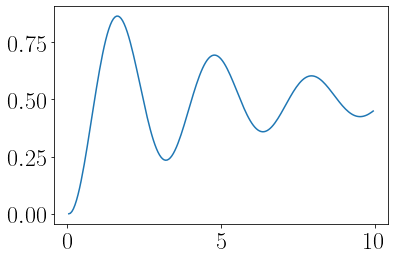

In [489]:
# Unconditional evolution
opts = Options(store_states=True)

result = mesolve(H, ψ0, t, c_ops=[L])

p1s = np.array([(rhoi*ψ1).tr() for rhoi in result.states])

plt.plot(t, p1s)

# plt.yscale('log')
plt.show()

In [490]:
# opts_stoch = Options(store_all_expect=True)
results = smesolve(H, ψ0, t, sc_ops=[L], e_ops=[ψ1], ntraj=5, store_all_expect=True)


20.0%. Run time:   0.01s. Est. time left: 00:00:00:00
40.0%. Run time:   0.01s. Est. time left: 00:00:00:00
60.0%. Run time:   0.02s. Est. time left: 00:00:00:00
80.0%. Run time:   0.02s. Est. time left: 00:00:00:00
Total run time:   0.02s


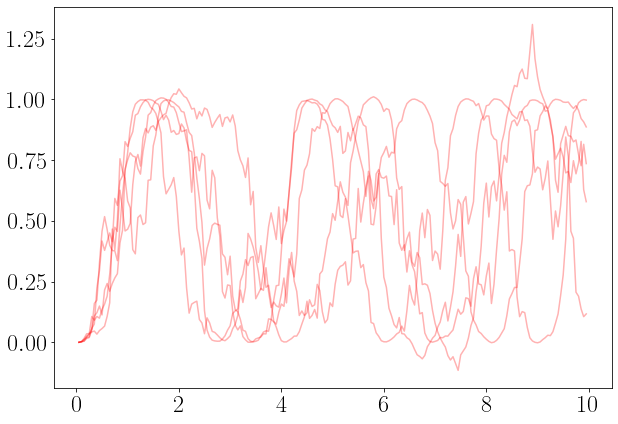

In [491]:
szes = np.real(results.runs_expect)[:,0,:]

fig = plt.figure(figsize=(10,7))
plt.plot(t, szes.T, color='r', alpha=0.3)

plt.show()

# Recreate Gabriel's figures 

In [492]:
# Create chi space
chi = np.linspace(-20, 20, 1000)
dchi = chi[1]-chi[0]

tc = [0.1, 0.2, 0.5, 1, 2.0]

# Compute tilted Liouvillians
liouvs = [tilted_liouvillian_diff(H, L, i, 1) for i in chi]
rhochi = [[vector_to_operator((liou * ti).expm()*rhovec) for liou in liouvs] for ti in tc]

# Take trace of all rhochis
pchis = np.array([[rho.tr() for rho in rhoix] for rhoix in rhochi])

In [493]:
dn = 0.01
n = np.arange(-5, 5, dn)

Pnt = dn*np.abs([trapz(np.exp(-1j*ni*chi)*pchis, chi, dx=dchi, axis=1) for ni in n])/(2*np.pi)

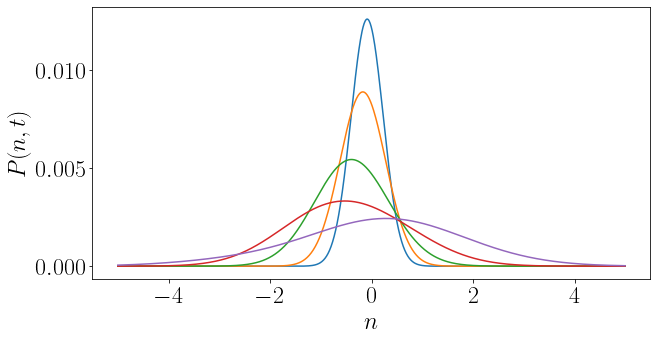

In [498]:
fig = plt.figure(figsize=(10, 5))

for PnTi in Pnt.T:
    plt.plot(n, PnTi, alpha=1)


plt.xlabel(r'$n$')
plt.ylabel(r'$P(n,t)$')
# plt.xlim([-10,10])

plt.show()

# fig.savefig('Pnt_exampleD.png', dpi=200, bbox_inches='tight')

# First Hitting time 

In [521]:
# Create chi space
chi = np.linspace(-10, 10, 500)
dchi = chi[1]-chi[0]

dt = 0.1
t = np.arange(0.05, 10, dt)

# Compute tilted Liouvillians
liouvs = [tilted_liouvillian_diff(H, L, i, 1) for i in chi]
rhochi = [[vector_to_operator((liou * ti).expm()*rhovec) for liou in liouvs] for ti in t]

# Take trace of all rhochis
pchis = np.array([[rho.tr() for rho in rhoix] for rhoix in rhochi])

In [525]:
dn = 0.1
n = np.arange(-50, 50, dn)
Pnt = dn*np.abs([trapz(np.exp(-1j*ni*chi)*pchis, chi, dx=dchi, axis=1) for ni in n])/(2*np.pi)

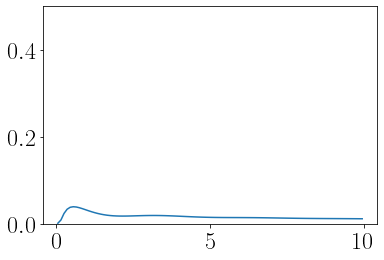

In [526]:
plt.plot(t, Pnt[490])

plt.ylim([0,0.5])
plt.show()

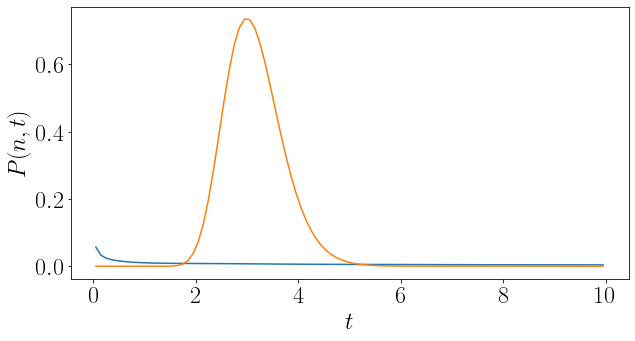

In [527]:
fig = plt.figure(figsize=(10, 5))

plt.plot(t, Pnt[500]/3)
plt.plot(t, Wald(Ω, κ, t))

plt.xlabel(r'$t$')
plt.ylabel(r'$P(n,t)$')


plt.show()

# fig.savefig('Pnt_exampleD.png', dpi=200, bbox_inches='tight')

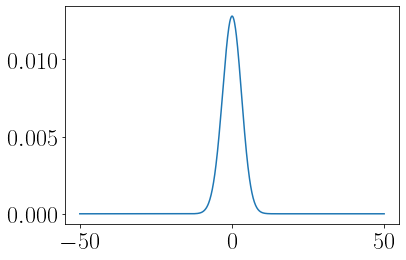

In [528]:
plt.plot(n, Pnt[:,80])

In [529]:
St = np.sum(Pnt[:len(n[n<1]),:], axis=0)

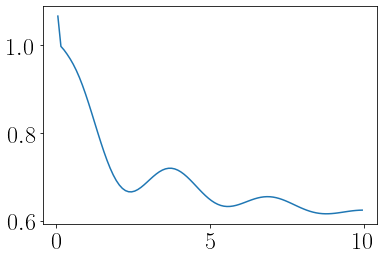

In [530]:
plt.plot(t, St)